# Data Prepocessing

The following steps are taken to preprocess the data.

- **1. Shapefiles**
    - Load shapefiles (stream gages, precipitation stations, boundaries).
    - Clean, simplify, and reproject shapefiles.
    - Clip and mask data based on region of interest.
    - Create Thiessen Polygons for precipitation stations for taking into account the spatial distibution of rain.
    - Extract relevant features (e.g., drainage area, station location).

- **2. Raster Data**
    - Load raster data (elevation, land cover).
    - Resample and align raster data layers.
    - Clip and mask data based on region of interest.
    - Extract key features (e.g., elevation, impervious surface).
    - Delineate watershed boundaries and extract watershed geomorphological characteristics
    - Normalize raster values.

- **3. Tabular Data**
    - Load time-series data (streamflow, precipitation).
    - Handle missing values and fill gaps.
    - Standardize time formats and indices.
    - Identify and remove outliers.
    - Resample and aggregate data to a uniform time step.
    - Create new features (e.g., moving averages).

- **4. Data Integration**
    - Spatially join shapefiles with raster and tabular data.
    - Merge time-series data based on time and location.
    - Aggregate raster features for each station or gage.

- **5. Selection of Storm Events**

- **6. Clark's parameter optmization**
    - Optmize Clark's parameters for the selected events
    - Spatially join the optmized parameters with shapefile data.

- **5. Machine Learning Preparation**
    - Scale and normalize features.
    - Split dataset into training and testing sets.
    - Encode categorical features.
    - Select most relevant features for training.


In [84]:
# Import modules
from pathlib import Path
import time
import sys
import geopandas as gpd
from plotnine import *
import warnings
from IPython.display import display, HTML, Markdown
from dotenv import load_dotenv
import os
import requests
import pandas as pd

In [32]:
# File paths
project_base_path = Path.cwd().parent.parent

In [33]:
# Add 'src' to system path
sys.path.append(str(project_base_path / 'src'))

# Ignore warnings
warnings.filterwarnings('ignore')

In [34]:
# Load tokens

load_dotenv(project_base_path / '.env')

NOAA_API_TOKEN = os.getenv('NOAA_API_TOKEN')


## 1. Shapefiles

### 1.1 Load shapefiles

In [49]:
# File paths
shapefiles_base_path = project_base_path / 'data'/ 'geo'/ 'shp'

dam_location_path = shapefiles_base_path / 'dams_location' / 'Dams.shp'

precip_stations_path = shapefiles_base_path / 'precipitation_stations' / 'precip_15.kmz'
streamgage_stations_path = shapefiles_base_path / 'streamgage_stations' / 'realstx.shp'

us_county_path = shapefiles_base_path / 'us_county' / 'tl_2024_us_county.shp'
us_state_path =  shapefiles_base_path / 'us_state' / 'tl_2024_us_state.shp'

world_utm_zones_path = shapefiles_base_path.parent / 'json' / 'World_UTM_Grid.geojson'

upper_hudson_basin_path = shapefiles_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
upper_hudson_basin_1km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_1km_buffer' / 'upper_hudson_basin_1km_buffer.shp'
upper_hudson_basin_5km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_5km_buffer' / 'upper_hudson_basin_5km_buffer.shp'
upper_hudson_basin_10km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_10km_buffer' / 'upper_hudson_basin_10km_buffer.shp'
upper_hudson_basin_30km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_30km_buffer' / 'upper_hudson_basin_30km_buffer.shp'

In [51]:
# Read shapefiles
try:
    start_time = time.time()

    precip_stations = gpd.read_file(precip_stations_path)
    streamgage_stations = gpd.read_file(streamgage_stations_path)

    dam_location = gpd.read_file(dam_location_path)

    us_county = gpd.read_file(us_county_path)
    us_state = gpd.read_file(us_state_path)

    world_utm_zones = gpd.read_file(world_utm_zones_path)

    upper_hudson_basin = gpd.read_file(upper_hudson_basin_path)
    upper_hudson_basin_1km_buffer = gpd.read_file(upper_hudson_basin_1km_buffer_path)
    upper_hudson_basin_5km_buffer = gpd.read_file(upper_hudson_basin_5km_buffer_path)
    upper_hudson_basin_10km_buffer = gpd.read_file(upper_hudson_basin_10km_buffer_path)
    upper_hudson_basin_30km_buffer = gpd.read_file(upper_hudson_basin_30km_buffer_path)

    end_time = time.time()

    print('Shapefiles read successfully. Time elapsed:', round(end_time - start_time, 2), 'seconds')
except Exception as err:
    print('Error reading shapefiles:', err)

Shapefiles read successfully. Time elapsed: 9.62 seconds


#### 1.2. Cleaning and Reprojection
##### 1.2.1 Cleaning
- **Precipitation Stations**

The Precipitation Station location covers the entire united states, is in kmz format and the ID station is encoded in HTML code, and has other irrelevant attributes. The following steps will be taken to clean the file:

- 1. Clip the data to have precipitation only in area of interest.
- 2. Decode the HTML code to extract the station ID and elevation.
- 3. Drop irrelevant attributes.

    **1. Clip the data**

    For the mask, we will use the study region + 30km buffer to make ensure that none of possible precipitation station is left outside. We will define later which station to use. 


In [53]:
# Clip the data
precip_stations_clipped = gpd.clip(precip_stations.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)




In [85]:
precip_stations_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 70 entries, 30 to 86
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            70 non-null     object        
 1   Name          70 non-null     object        
 2   description   70 non-null     object        
 3   timestamp     0 non-null      datetime64[ms]
 4   begin         0 non-null      datetime64[ms]
 5   end           0 non-null      datetime64[ms]
 6   altitudeMode  0 non-null      object        
 7   tessellate    70 non-null     int32         
 8   extrude       70 non-null     int32         
 9   visibility    70 non-null     int32         
 10  drawOrder     0 non-null      float64       
 11  icon          0 non-null      object        
 12  geometry      70 non-null     geometry      
 13  layer         70 non-null     object        
dtypes: datetime64[ms](3), float64(1), geometry(1), int32(3), object(6)
memory usage: 7.4+ KB

In [106]:
geom_merged = pd.concat(
    [
        #precip_stations_clipped[['geometry']].assign(LAYER='Preciptation Station'),
        upper_hudson_basin.to_crs(precip_stations_clipped.crs)[['geometry']].assign(LAYER='Upper Hudson'),
        upper_hudson_basin_10km_buffer[['geometry']].assign(LAYER='10km buffer'),
        upper_hudson_basin_30km_buffer[['geometry']].assign(LAYER='30km buffer')
    ]
)

precip_station_map2 = (
    ggplot(geom_merged)
    + geom_map(
        mapping=aes(geometry='geometry', color = 'LAYER'),
        fill = None
    )
    + geom_map(
        data = precip_stations_clipped[['geometry']].assign(LAYER='Preciptation Station'),
        mapping=aes(gemetry='geometry', color='LAYER')
    )

)
precip_station_map2.draw()
precip_station_map2.save('map2.png')

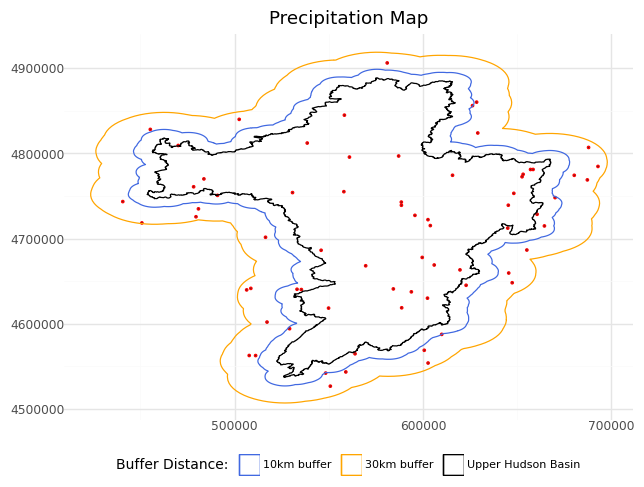

In [105]:
# Precipitation map
precip_station_map = (
    ggplot(precip_stations_clipped)
    + geom_map(
        mapping=aes(geometry='geometry'),
        color = 'red'
    )
    + geom_map(
        data=upper_hudson_basin_10km_buffer,
        mapping=aes(geometry='geometry', color='"10km buffer"'),
        inherit_aes=False,
        fill=None
    )
    + geom_map(
        data=upper_hudson_basin_30km_buffer,
        mapping=aes(geometry='geometry', color='"30km buffer"'),
        inherit_aes=False,
        fill=None
    )
    + geom_map(
        data=upper_hudson_basin.to_crs(precip_stations_clipped.crs),
        mapping=aes(geometry='geometry', color='"Upper Hudson Basin"'),
        inherit_aes=False,
        fill=None
    )
    + labs(title='Precipitation Map')
    + scale_color_manual(
        name='Buffer Distance:',
        values={
            '10km buffer': 'royalblue',
            '30km buffer': 'orange',
            'Upper Hudson Basin': 'black'
            }
    )
    + theme_minimal()
    + theme(
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position='bottom'
    )
)
precip_station_map.save('prec_map1.png')
precip_station_map.draw()



In [24]:
from bs4 import BeautifulSoup

html_code = '''\n    \n    <table>\n    <tr><td>ID: COOP:267369</td></tr>\n    <tr><td>COUNTRY: United States</td></tr>\n    <tr><td>LATITUDE: 35.4661</td></tr>\n    <tr><td>LONGITUDE: -114.92161</td></tr>\n    <tr><td>ELEVATION: 1079 m.</td></tr>\n    <tr><td></td></tr>\n    </table>\n    <table>\n    <tr><td><form action="https://www.ncdc.noaa.gov/cdo-web/mapReview" method="post">\n        <input type="hidden" name="_dataSet" value="PRECIP_15"/>\n        <input type="hidden" name="_stationId" value="COOP:267369"/>\n        <input type="submit" value="Access Station Data"/>\n    </form></td></tr>\n    </table> \n  '''

soup = BeautifulSoup(html_code, 'html.parser')

id_value = soup.find('td').text.split(': ')[1]
elevation = soup.find_all('td')[4].text.split(': ')[1]

soup.find_all('td')
elevation

'1079 m.'

In [8]:
precip_stations.head()

,id,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry
0,1,"UTICA 7 SSW, NY US",\n \n <table>\n <tr><td>ID: COOP:3087...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (-75.26667 43 0)
1,2,"CHARLOTTEBURG RESERVOIR, NJ US",\n \n <table>\n <tr><td>ID: COOP:2815...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (-74.42477 41.02996 0)
2,3,"WANAQUE RAYMOND DAM, NJ US",\n \n <table>\n <tr><td>ID: COOP:2891...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (-74.29718 41.04156 0)
3,4,"SEARCHLIGHT, NV US",\n \n <table>\n <tr><td>ID: COOP:2673...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (-114.92161 35.4661 0)
4,5,"OVERTON, NV US",\n \n <table>\n <tr><td>ID: COOP:2658...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (-114.4582 36.55006 0)


In [7]:
base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/'
headers = {"Token":NOAA_API_TOKEN}
endpoint = 'datasets'
parameters = {'stationid':'COOP:267369'}


response = requests.get(url=base_url + endpoint, headers=headers, params=parameters)
response.json()



{'metadata': {'resultset': {'offset': 1, 'count': 2, 'limit': 25}},
 'results': [{'uid': 'gov.noaa.ncdc:C00505',
   'mindate': '1970-05-12',
   'maxdate': '2014-01-01',
   'name': 'Precipitation 15 Minute',
   'datacoverage': 0.25,
   'id': 'PRECIP_15'},
  {'uid': 'gov.noaa.ncdc:C00313',
   'mindate': '1900-01-01',
   'maxdate': '2014-01-01',
   'name': 'Precipitation Hourly',
   'datacoverage': 1,
   'id': 'PRECIP_HLY'}]}

In [8]:
parameters2 = {'stationid':'COOP:267369',
               'datasetid':'PRECIP_15',
               'startdate':'2012-10-31',
               'enddate':'2012-12-31'}
response2 = requests.get(url=base_url + 'data', headers=headers, params=parameters2)
response2.json()

{'metadata': {'resultset': {'offset': 1, 'count': 11, 'limit': 25}},
 'results': [{'date': '2012-10-31T23:45:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-11-01T00:00:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-11-01T00:15:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': 'g,,HT',
   'value': 0},
  {'date': '2012-11-01T00:15:00',
   'datatype': 'QPCP',
   'station': 'COOP:267369',
   'attributes': 'g,,HT',
   'value': 0},
  {'date': '2012-11-30T23:45:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-12-01T00:00:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': ',,HT',
   'value': 81},
  {'date': '2012-12-01T00:15:00',
   'datatype': 'QGAG',
   'station': 'COOP:267369',
   'attributes': 'N,,HT',
   'value': 81},
  {'date': '2012-12-01T

In [26]:
response1.json()

{}

#### 1.2.2. Reprojection

When working with geospatial data in the Upper Hudson River Basin, selecting an appropriate map projection is essential to ensure the accuracy of spatial attribute calculations, such as area and perimeter. For this study, the **NAD83 datum** has been chosen as it is widely used for regional geospatial analysis within the United States. Specifically, we will utilize the **NAD83 / UTM Zone 18N (EPSG:26918)** projection, which is well-suited for the geographic extent of the Hudson River Basin.

The UTM Zone 18N projection minimizes distortions in distance and area measurements by dividing the Earth into zones optimized for small regions. This makes it ideal for hydrological studies and sub-basin analyses, where precision is critical. The projection's use of meters as the measurement unit simplifies calculations of spatial attributes, ensuring consistency and ease of interpretation.

For larger-scale or cross-basin analyses, equal-area projections such as **Albers Equal Area (EPSG:5070)** or **Lambert Conformal Conic (EPSG:102009)** can be considered. However, for this focused study on sub-basins within the Upper Hudson River region, the selected UTM projection provides the most practical and accurate framework.

This notebook demonstrates the workflow of analyzing geospatial data with Python, starting from data preprocessing, reprojecting datasets, and extracting key attributes, all while leveraging the NAD83 datum for spatial accuracy.

In [27]:
# Filter UTM bounds to be within the bounds of the upper hudson basin
upper_hudson_basin_bounds = list(upper_hudson_basin.total_bounds)

utm_bounds = world_utm_zones.bounds

utm_intersecting_bounds = (
    (utm_bounds['minx'] < upper_hudson_basin_bounds[2]) &  # UTM left < Basin right
    (utm_bounds['maxx'] > upper_hudson_basin_bounds[0]) &  # UTM right > Basin left
    (utm_bounds['miny'] < upper_hudson_basin_bounds[3]) &  # UTM bottom < Basin top
    (utm_bounds['maxy'] > upper_hudson_basin_bounds[1])    # UTM top > Basin bottom
)
world_utm_zones_filtered = world_utm_zones[utm_intersecting_bounds]

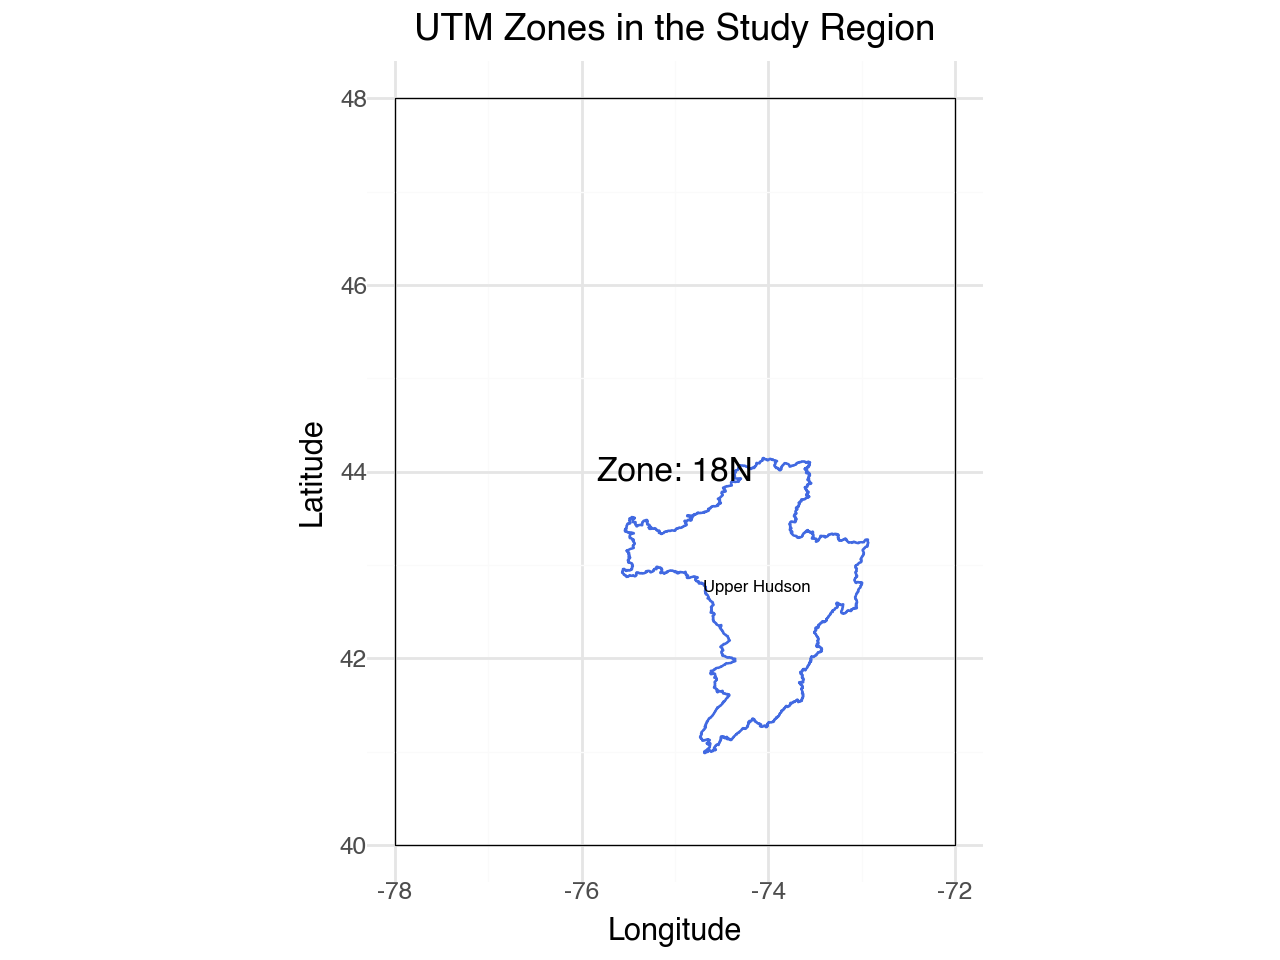

In [51]:
world_utm_zones_filtered['lon'] = world_utm_zones_filtered.centroid.x
world_utm_zones_filtered['lat'] = world_utm_zones_filtered.centroid.y

world_utm_zones_filtered['ZONE_str'] = 'Zone: ' + world_utm_zones_filtered['ZONE'].astype(str)+'N'
utm_zones_map = (
    ggplot(upper_hudson_basin)
        + geom_map(
            mapping=aes(geometry="geometry"),
            inherit_aes=True, 
            color = 'royalblue',
            fill=None
        )
         + geom_text(
            mapping=aes(x="lon", y="lat", label="name"),
            size=6,
            color="black"
        )
        + geom_map(
            mapping=aes(geometry="geometry"),
            data=world_utm_zones_filtered,
            inherit_aes=False,
            color="black",
            size=0.25,
            fill = None
        )
        + geom_text(
            mapping=aes(x="lon", y="lat", label="ZONE_str"),
            size=12,
            color="black",
            data = world_utm_zones_filtered,
            inherit_aes=False
        )
        + coord_fixed()
        + theme_minimal()
        + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
        + labs(title="UTM Zones in the Study Region", x="Longitude", y="Latitude")
    
)
utm_zones_map
                 

In [29]:
epsg = 26918 # UTM Zone 18N

In [30]:
# us_state
if us_state[~us_state.is_valid].empty:
    print('No invalid geometry for us_state')
else:
    print('The following geomtries from us_state are invalid')
    us_state[~us_state.is_valid]

# us_county
if us_county[~us_county.is_valid].empty:
    print('No invalid geometry for us_county')
else:
    print('The following geomtries from us_county are invalid')
    us_county[~us_county.is_valid]

No invalid geometry for us_state
No invalid geometry for us_county


In [31]:
us_state[~us_state.is_valid]

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
